In [ ]:
# Code snippet for rendering animations in the docs
from IPython.display import HTML
import warnings
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
import matplotlib.pyplot as plt

def render_ani_func(f):
    om.utils.disable_interactive_backend_switching()
    plt.switch_backend('Agg')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ani = f()
    %matplotlib inline
    om.utils.enable_interactive_backend_switching()

    vid = HTML(ani.to_html5_video())
    plt.close('all')
    return vid

```{tip}
Download this tutorial as a {download}`Jupyter notebook <converted/motion_compensation.ipynb>`, or a {download}`python script <converted/motion_compensation.py>` with code cells.
```

# Tutorial 3: Motion Compensation and Ratiometry with Di-4-ANEPPS

In this tutorial, we will discuss the analysis of ratiometric optical mapping data showing the ventricular surface of a contracting heart. The heart was stained with Di-4-ANEPPS and imaged using an alternating green and blue illumination at 500fps as described in Kappadan et al. 2020. The tissue was illuminated in every odd frame with green light and in every even frame with blue light, respectively. This approach i sometimess referred to as 'excitation ratiometry'. After numerical motion tracking and stabilization, the green and blue videos are divided by each other to obtain a motion-stabilized ratiometric video. Using this method, both motion artifacts as well as illumination artifacts (which also lead to motion artifacts) can be significantly reduced. 

First, we load the video data, which is stored as a single file (`Example_05_Ratiometry.npy`) containing the two green and blue videos in an interleaved fashion (frame 1 = green, frame 2 = blue, frame 3 = green, etc.). Using optimap's `load_video()` function, we can specify to load only every 2nd frame and to start reading from the first or the second frame, respectively:

In [1]:
import optimap as om
# import monochrome as mc  # remove this if you don't have monochrome installed

#filename = om.utils.retrieve_example_data('Example_01_Sinus_Rabbit_Basler.npy')
filename = 'example_data/Example_05_Ratiometry.npy'
video_blue = om.load_video(filename, start_frame=0, step=2)
video_green = om.load_video(filename, start_frame=1, step=2)


video_green = om.video.rotate_left(video_green)
video_green = om.video.rotate_left(video_green)

video_blue = om.video.rotate_left(video_blue)
video_blue = om.video.rotate_left(video_blue)

Alternatively, one could load the video and manually split the video into the green and blue videos (`video_green = video[::2,:,:]` etc.).

When we play the two videos next to each other we notice that there is signal in only the green video but not in the blue video:

In [2]:
om.video.play2(video_green, video_blue, title1="green video with signal", title2="blue video without signal");

In [ ]:
render_ani_func(lambda: om.video.play2(video_green, 1, title="green video with signal", interval=20))

If we plot and compare two optical traces from the green and blue videos respectively, we can see on average stronger intensity fluctuations in the green video:

In [14]:
om.trace.set_default_trace_window('disc') # the trace is sample from a disc-shaped region with a diameter specified by 'size'
om.compare_traces([video_green, video_blue],labels=['green','blue'], size=5)

Note that both videos contain strong motion artifacts. In the green video, parts of the intensity fluctuations are caused by motion and parts are caused by the optical signal related to the action potential. In the blue video, nearly all fluctuations are caused by motion. Let's look at a few specific examples. In the code block above, the function ``compare_traces()`` was started in interactive mode because we did not provide specific coordinates as arguments. We can also provide specific coordinates (e.g. the pixel at (50,50)) as follows:

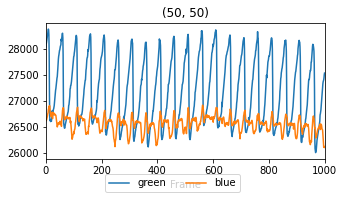

In [16]:
om.compare_traces([video_green, video_blue],[50,50],labels=['green','blue'], size=5)

In this example, the green optical trace shows steep downstrokes typical for the upstroke of the action potential, whereas the blue trace exhibits much weaker and inconsistent intensity fluctuations overall. These fluctuations are largely caused by motion.

In [8]:
traces_blue, positions = om.select_traces(video_blue)
traces_green = om.extract_traces(video_green, positions)

(array([[24449.56, 20558.76, 23083.12],
        [24488.08, 20529.68, 23117.52],
        [24509.48, 20500.36, 23186.84],
        ...,
        [23722.32, 19922.  , 23024.28],
        [23637.6 , 19866.08, 22930.12],
        [23631.88, 19855.96, 22914.72]]),
 [(45, 65), (66, 76), (82, 64)])

Now let's perform numerical motion tracking and motion-stabilization with the green and blue videos:

In [18]:
warped_green = om.motion_compensate(video_green, contrast_kernel=5, ref_frame=0)
warped_blue = om.motion_compensate(video_blue, contrast_kernel=5, ref_frame=0)
om.video.playn([video_green, warped_green, video_blue, warped_blue],
               titles=["video green", "stabilized video green", "video blue", "stabilized video blue"], figsize=(8, 3.5));

calculating flows (GPU): 100%|██████████| 1000/1000 [00:00<00:00, 1290.36it/s]


Now let's look at how the green and blue traces have changed with the motion-stabilization using the ``compare_traces()`` function in interactive mode:

In [22]:
om.compare_traces([video_green, warped_green],labels=['green','warped green'], size=5)